# DEEP LEARNING FOR SEQUENTIAL DATA

## Coding Questions

This section consists of coding questions.  
The task we are considering in this section is the text classification task. In this section, some code has been provided to help you get started. For each cell marked with **# Insert your code here**, these are placeholders where you **must** supply your own codes when instructed.
This section consists of 5 parts:
* Part 0: Downloading and preprocessing data. This part has been completed. No marks are allocated for this part.
* Part 1: Coding assessment on using Word2Vect to transform texts to vectors (20 marks).
* Part 2: Coding assessment on Text CNN for sequence modeling and neural embedding (10 marks).
* Part 3: Coding assessment on RNNs for sequence modeling and neural embedding (32 marks).
* Part 4: Coding assessment on Transformer for sequence modeling and neural embedding and the overall ranking (23 marks).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [1]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 0: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold"><span></div>

The dataset we use for this task is a question classification dataset for which the training set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).

In this task, we will utilize a subset of this dataset, containing $2,000$ questions for training and validation. We will use 80% of those 2000 questions for trainning and the rest for validation.


Preprocessing data is a crucial initial step in any machine learning or deep learning project. The *TextDataManager* class simplifies the process by providing functionalities to download and preprocess data specifically designed for the subsequent questions in this task. It is highly recommended to gain a comprehensive understanding of the class's functionality by **carefully reading** the content provided in the *TextDataManager.py* file before proceeding to answer the questions in Part 1.

In [2]:
from TextDataManager import SimpleTextDataset as DataManager

print('Loading data...')
DataManager.maybe_download("data", "train_2000.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("data/", ["train_2000.label"])

Loading data...
Downloaded successfully train_2000.label

Sample questions and corresponding labels... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
['DESC', 'ENTY', 'DESC', 'ENTY', 'ABBR']


In [3]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

In [4]:
print(dm.train_str_questions)
print(dm.train_numeral_data.shape)  
print(dm.valid_numeral_data.shape)  
print(dm.train_numeral_labels.shape)

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?', 'ind what contemptible scoundrel stole the cork from my lunch ?', "gr what team did baseball 's st. louis browns become ?", 'title what is the oldest profession ?', 'def what are liver enzymes ?', 'ind name the scar-faced bounty hunter of the old west .', 'date when was ozzy osbourne born ?', 'reason why do heavier objects travel downhill faster ?', 'ind who was the pride of the yankees ?', 'ind who killed gandhi ?', 'event what is considered the costliest disaster the insurance industry has ever faced ?', 'state what sprawling u.s. state boasts the most airports ?', 'desc what did the only repealed amendment to the u.s. constitution deal with ?', 'count how many jews were executed in conce

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

## <span style="color:#0b486b">Part 1: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 marks]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a classifier using Logistic Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [5]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np

#### <span style="color:red">**Question 1.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [6]:
word2vect = api.load('glove-wiki-gigaword-100')

In [7]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word)
    except: # word not in the vocabulary
        vector = np.zeros(100)
    return vector

#### <span style="color:red">**Question 1.2**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[T]\times v[T]$ where $T$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [8]:
def softmax(vector):
    numerator_vector = np.exp(vector)
    denominator = numerator_vector.sum()
    return numerator_vector / denominator

In [9]:
def get_sentence_vector(sentence, important_score=None, model=None):
    sentence = sentence.split(' ')
    length = len(sentence)
    final_vector = np.zeros(100)
    if important_score is None:
        important_score = np.ones(length)
    important_weight = softmax(important_score)
    for i in range(len(sentence)):
        word = sentence[i]
        word_vector = get_word_vector(word, model)
        weight = important_weight[i]
        weighted_word_vector = np.dot(weight, word_vector)
        final_vector += weighted_word_vector
    return final_vector

#### <span style="color:red">**Question 1.3**</span> 

**Write code to transform questions in *dm.train_str_questions* and *dm.valid_str_questions* to feature vectors. Note that after running the following cells, you must have $X\_train$ and $X\_valid$ which are two numpy arrays of the feature vectors and $y\_train$ and $y\_valid$ which are two arrays of numeric labels (Hint: *dm.train_numeral_labels* and *dm.valid_numeral_labels*). You can add more lines to the following cells if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[4 marks]</span></div> 

In [10]:
score = 1
scores = []
for _ in range(100):
    scores.append(score)
    score *= 0.9

In [11]:
print("Transform training set to feature vectors...")

X_train = []
y_train = []

for i in range(len(dm.train_str_questions)):
    question = dm.train_str_questions[i].split(' ')
    important_score = scores[:len(question)]
    X_train.append(get_sentence_vector(dm.train_str_questions[i], important_score, word2vect))
    y_train.append(dm.train_numeral_labels[i])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

Transform training set to feature vectors...


In [12]:
print("Transform validation set to feature vectors...")

X_valid = []
y_valid = []

for i in range(len(dm.valid_str_questions)):
    question = dm.valid_str_questions[i].split(' ')
    important_score = scores[:len(question)]
    X_valid.append(get_sentence_vector(dm.valid_str_questions[i], important_score, word2vect))
    y_valid.append(dm.valid_numeral_labels[i])
    
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

Transform validation set to feature vectors...


#### <span style="color:red">**Question 1.4**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in scikit-learn to scale both training and validation sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)

#### <span style="color:red">**Question 1.5**</span>
**Train a Logistic Regression model on the training set and then evaluate on the validation set.**
<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [14]:
# Insert your code for training here

from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [15]:
# Insert your code for validation here

from sklearn.metrics import accuracy_score

y_pred = lr_model.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)

print("Accuracy when evaluated on the validation set:", accuracy)

Accuracy when evaluated on the validation set: 0.895


### **Embedding visualization**

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $L^2$ norm.**

In [16]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

#### <span style="color:red">**Question 1.6** </span> 

**Write code for the `function find_most_similar(word=None, k=5, model=None)` which returns a list of the top-`k` most similar words (in descending order) for a given word. This similarity is based on the cosine similarity of embedding vectors obtained from the pretrained model `glove-wiki-gigaword-100` (see Question 1.1). The parameter `include_cur_word` specifies whether the given word should be included in the returned output or not. This means that if `include_cur_word=True`, the function will return `k+1` words.** 

<div style="text-align: right"><span style="color:red">[3 marks]</span></div>

In [17]:
def find_most_similar(word=None, k=5, model=None, include_cur_word=False):
    try:
        vocab = list(model.key_to_index.keys())
        target_word_vector = get_word_vector(word, model)
        all_words_similarities = []
        top_k_words = []
        top_k_embedding_vectors = []
        top_k_similarities = []
    
        for word in vocab:
            word_vector = get_word_vector(word, model)
            similarity = cosine_similarity(word_vector, target_word_vector)
            all_words_similarities.append((word, word_vector, similarity))
            
        # sort in descending order
        all_words_similarities = sorted(all_words_similarities, key=lambda x: x[2], reverse=True)
        
        for i in range(k+1):
            top_k_words.append(all_words_similarities[i][0])
            top_k_embedding_vectors.append(all_words_similarities[i][1])
            top_k_similarities.append(all_words_similarities[i][2])
            
        if not include_cur_word:
            top_k_words.pop(0)
            top_k_embedding_vectors.pop(0)
            top_k_similarities.pop(0)
        
        return (top_k_words, top_k_embedding_vectors)
        
    except: # Word not in the vocabulary
        print("Word is not in the dictionary!")

Here is the example of the above function. You can check your implementation using the provided `result`. As you can observe, the `result` makes sense which demonstrates that the embedding matrix is meaningful.

In [18]:
result = ['computer','computers','software','technology','pc','hardware','internet','desktop','electronic','systems','computing']
output = find_most_similar(word='computer', k=10, model=word2vect, include_cur_word=True)[0]
if output == result:
    print("Your implementation is correct.")
else:
    print("Your implementation is not correct.")

Your implementation is correct.


#### <span style="color:red">**Question 1.7** </span> 
**Implement the `plot2D_with_groups(word_list, model, k=10)` function to visualize groups of similar words in 2D space. The `word_list` parameter is a list of words, and for each word in the `word_list`, find its top-`k` most similar words (which forms a group) using the `find_most_similar` function. Use tSNE to project embedding vectors into 2D space and plot groups with different colors. You can use the colormaps from `matplotlib`, i.e., `cmap = plt.get_cmap('brg')`.**

**The figure bellow is the output obtained by running `plot2D_with_groups` using the input `word_list=['an', 'introduction', 'to', 'deep', 'learning']`. Note that the words within the `word_list` are also visualized (in black) as shown in the figure.**

<img src="./images/2Dtsne.png" align="center" width=600/>

**As you can observe, words within each group tend to be closer to each other, while words from different groups are more distant.**

<div style="text-align: right"><span style="color:red">[5 marks]</span></div>

In [19]:
def get_all_words(word_list, k, model, include_cur_word):
    lst = []
    for word in word_list:
        temp = find_most_similar(word=word, k=k, model=model, include_cur_word=include_cur_word)[0]
        for word in temp:
            lst.append(word)
    return lst

In [20]:
def get_all_embeddings(word_list, k, model, include_cur_word):
    lst = []
    for word in word_list:
        temp = find_most_similar(word=word, k=k, model=model, include_cur_word=include_cur_word)[1]
        for embedding in temp:
            lst.append(embedding)
    return lst

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

cmap = plt.get_cmap('brg')

def plot2D_with_groups(word_list=None, k=10, model=None):
    plt.figure(figsize=(10,10))
    all_words = get_all_words(word_list, k, model, True)
    all_embeddings = np.array(get_all_embeddings(word_list, k, model, True))
    low_dim_embs = tsne.fit_transform(all_embeddings)
    
    for i, label in enumerate(all_words):
        x, y = low_dim_embs[i, :]
        values = np.linspace(0, 1, len(word_list))
        color = cmap(values[i//(k+1)])
        
        plt.scatter(x, y, c=color)
        
        # set color for label
        if label not in word_list:   # same color as point
            plt.annotate(label, 
                         xy=(x, y),
                         xytext=(5,2),
                         textcoords='offset points',
                         ha='left',
                         va='bottom',
                         color=color)
            
        else:   # color = 'black' and bold the label
            plt.annotate(label, 
                         xy=(x, y),
                         xytext=(5,2),
                         textcoords='offset points',
                         ha='left',
                         va='bottom',
                         color='black',
                         fontweight='bold')

C:\Users\Chong Ming Sheng\AppData\Local\Temp\ipykernel_19400\1301415364.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color)


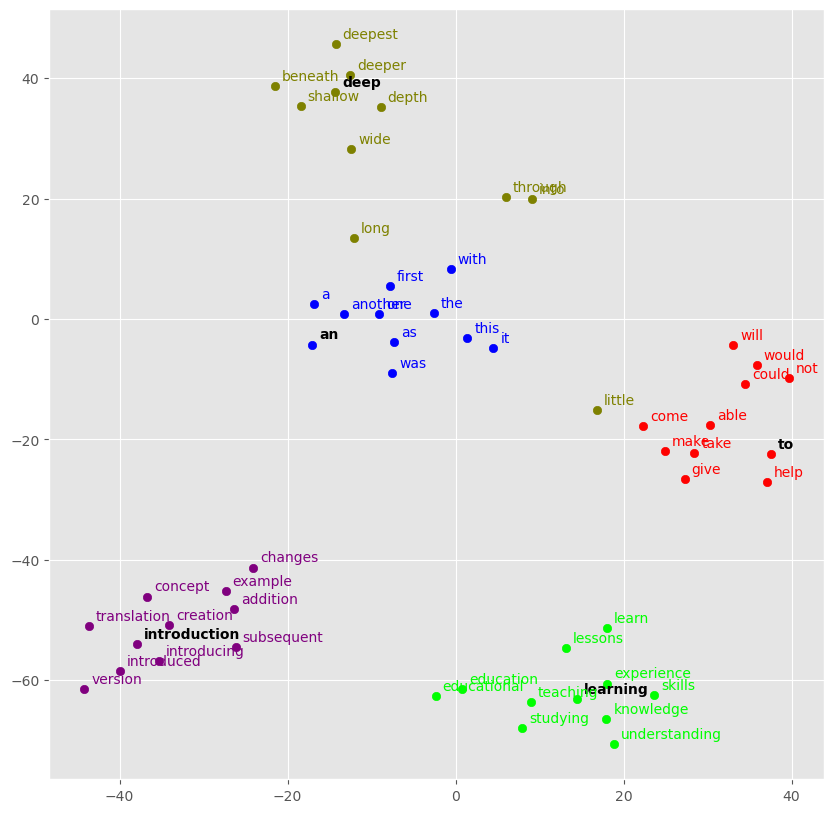

In [22]:
word_list = ['an', 'introduction', 'to', 'deep', 'learning']
plot2D_with_groups(word_list=word_list, k=10, model=word2vect)

## <span style="color:#0b486b">Part 2: Text CNN for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 marks]<span></div>

#### <span style="color:red">**Question 2.1**</span> 

**In what follows, you are required to complete the code for Text CNN for sentence classification. The paper of Text CNN can be found at this [link](https://www.aclweb.org/anthology/D14-1181.pdf). Here is the description of the Text CNN that you need to construct.**
- There are three attributes (properties or instance variables): *embed_size, state_size, data_manager*.
  - `embed_size`: the dimension of the vector space for which the words are embedded to using the embedding matrix.
  - `state_size`: the number of filters used in *Conv1D* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)).
  - `data_manager`: the data manager to store information of the dataset.
- The detail of the computational process is as follows:
  - Given input $x$, we embed $x$ using the embedding matrix to obtain an $3D$ tensor $[batch\_size \times maxlen \times embed\_size]$ as $h$.
  - We feed $h$ to three *Conv1D* layers, each of which has $state\_size$ filters, padding=same, activation= relu, and $kernel\_size= 3, 5, 7$ respectively to obtain $h1, h2, h3$. Note that each $h1, h2, h3$ is a 3D tensor with the shape $[batch\_size \times output\_size \times state\_size]$.
  - We then apply *GlobalMaxPool1D()* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)) over $h1, h2, h3$ to obtain 2D tensors stored in $h1, h2, h3$ again.
  - We then concatenate three 2D tensors $h1, h2, h3$ to obtain $h$. Note that you need to specify the axis to concatenate.
  - We finally build up one dense layer on the top of $h$ for classification.
  
  <div style="text-align: right"><span style="color:red">[8 marks]</span></div>
  

In [23]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size, mask_zero=True)(x)
        h1 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=3, padding='same', activation='relu')(h)
        h2 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=5, padding='same', activation='relu')(h)
        h3 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=7, padding='same', activation='relu')(h)
        h1 = tf.keras.layers.GlobalMaxPooling1D()(h1)
        h2 = tf.keras.layers.GlobalMaxPooling1D()(h2)
        h3 = tf.keras.layers.GlobalMaxPooling1D()(h3)
        h = tf.concat([h1, h2, h3], axis=1)
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h) 
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 2.2**</span> 
**Here is the code to test TextCNN above. You can observe that TextCNN outperforms the traditional approach Word2Vect with Logistic Regression for this task. The reason is that TextCNN enables us to automatically learn the feature that fits to the task. This makes deep learning different from hand-crafted feature approaches. Complete the code to test the model. Note that when compiling the model, you can use the Adam optimizer.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [31]:
text_cnn = TextCNN(data_manager=dm)
text_cnn.build()

# Insert your code here 
# You are required to compile the model and train the model on 20 epochs
text_cnn.compile_model(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
text_cnn_history = text_cnn.fit(dm.tf_train_set.batch(64), validation_data=dm.tf_valid_set.batch(64), epochs=20)

Epoch 1/20
25/25 [==============================] - 2s 57ms/step - loss: 1.6773 - accuracy: 0.2969 - val_loss: 1.5337 - val_accuracy: 0.4200
Epoch 2/20
25/25 [==============================] - 1s 42ms/step - loss: 1.3121 - accuracy: 0.6850 - val_loss: 1.0992 - val_accuracy: 0.8025
Epoch 3/20
25/25 [==============================] - 1s 45ms/step - loss: 0.7425 - accuracy: 0.8863 - val_loss: 0.5088 - val_accuracy: 0.9000
Epoch 4/20
25/25 [==============================] - 1s 46ms/step - loss: 0.2978 - accuracy: 0.9525 - val_loss: 0.2465 - val_accuracy: 0.9500
Epoch 5/20
25/25 [==============================] - 1s 37ms/step - loss: 0.1417 - accuracy: 0.9706 - val_loss: 0.1645 - val_accuracy: 0.9550
Epoch 6/20
25/25 [==============================] - 1s 41ms/step - loss: 0.0813 - accuracy: 0.9887 - val_loss: 0.1291 - val_accuracy: 0.9625
Epoch 7/20
25/25 [==============================] - 1s 38ms/step - loss: 0.0503 - accuracy: 0.9975 - val_loss: 0.1102 - val_accuracy: 0.9575
Epoch 8/20
25

In [32]:
print("Accuracy when evaluated on the validation set:", text_cnn_history.history["val_accuracy"][-1])

Accuracy when evaluated on the validation set: 0.9649999737739563


## <span style="color:#0b486b">Part 3: RNN-based models for sequence modeling and neural embedding</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 32 marks]<span></div>

### <span style="color:#0b486b">3.1. RNNs with different cell types</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <span style="color:red">**Question 3.1.1**</span> 
**In this part, you need to construct a vanilla RNN to learn from the dataset of interest. Basically, you are required to construct the class RNN with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can take one of the three values, i.e., `simple_rnn`, `gru`, or `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 marks]</span></div>

In [31]:
class BaseRNN:
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 64], data_manager=None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size + 1 
        
    # return the corresponding memory cell
    @staticmethod
    def get_layer(cell_type='gru', state_size=128, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.GRU(units=state_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            return tf.keras.layers.LSTM(units=state_size, return_sequences=return_sequences, activation=activation)
        else:
            return tf.keras.layers.SimpleRNN(units=state_size, return_sequences=return_sequences, activation=activation)
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            if i < (num_layers - 1):
                h = BaseRNN.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=True)(h)
            else:
                h = BaseRNN.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=False)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 3.1.2**</span> 
**Run with simple RNN ('simple_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [35]:
simple_rnn = BaseRNN(cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
simple_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
simple_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
simple_rnn_history = simple_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 5s 99ms/step - loss: 0.9311 - accuracy: 0.6731 - val_loss: 0.3167 - val_accuracy: 0.9100
Epoch 2/20
25/25 [==============================] - 2s 84ms/step - loss: 0.1823 - accuracy: 0.9488 - val_loss: 0.1709 - val_accuracy: 0.9400
Epoch 3/20
25/25 [==============================] - 2s 84ms/step - loss: 0.0904 - accuracy: 0.9712 - val_loss: 0.1523 - val_accuracy: 0.9450
Epoch 4/20
25/25 [==============================] - 2s 84ms/step - loss: 0.0440 - accuracy: 0.9869 - val_loss: 0.1469 - val_accuracy: 0.9450
Epoch 5/20
25/25 [==============================] - 2s 81ms/step - loss: 0.0294 - accuracy: 0.9925 - val_loss: 0.1235 - val_accuracy: 0.9650
Epoch 6/20
25/25 [==============================] - 2s 84ms/step - loss: 0.0309 - accuracy: 0.9925 - val_loss: 0.1268 - val_accuracy: 0.9525
Epoch 7/20
25/25 [==============================] - 2s 84ms/step - loss: 0.0059 - accuracy: 0.9994 - val_loss: 0.1172 - val_accuracy: 0.9750
Epoch 8/20
25

In [36]:
print("Accuracy when evaluated on the validation set:", simple_rnn_history.history["val_accuracy"][-1])

Accuracy when evaluated on the validation set: 0.9674999713897705


#### <span style="color:red">**Question 3.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [39]:
gru_rnn = BaseRNN(cell_type='gru', embed_size=128, state_sizes=[64,128], data_manager=dm)
gru_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
gru_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_rnn_history = gru_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 15s 266ms/step - loss: 1.5137 - accuracy: 0.3594 - val_loss: 0.9211 - val_accuracy: 0.6575
Epoch 2/20
25/25 [==============================] - 3s 137ms/step - loss: 0.4265 - accuracy: 0.8606 - val_loss: 0.2672 - val_accuracy: 0.9225
Epoch 3/20
25/25 [==============================] - 3s 140ms/step - loss: 0.1291 - accuracy: 0.9650 - val_loss: 0.1668 - val_accuracy: 0.9550
Epoch 4/20
25/25 [==============================] - 4s 141ms/step - loss: 0.0588 - accuracy: 0.9887 - val_loss: 0.1578 - val_accuracy: 0.9600
Epoch 5/20
25/25 [==============================] - 4s 143ms/step - loss: 0.0268 - accuracy: 0.9937 - val_loss: 0.2128 - val_accuracy: 0.9600
Epoch 6/20
25/25 [==============================] - 4s 145ms/step - loss: 0.0171 - accuracy: 0.9944 - val_loss: 0.1689 - val_accuracy: 0.9625
Epoch 7/20
25/25 [==============================] - 4s 147ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.1945 - val_accuracy: 0.9550
Epoch

In [40]:
print("Accuracy when evaluated on the validation set:", gru_rnn_history.history["val_accuracy"][-1])

Accuracy when evaluated on the validation set: 0.9649999737739563


#### <span style="color:red">**Question 3.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [41]:
lstm_rnn = BaseRNN(cell_type='lstm', embed_size=128, state_sizes=[64,128], data_manager=dm)
lstm_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
lstm_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_rnn_history = lstm_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 15s 265ms/step - loss: 1.2928 - accuracy: 0.5156 - val_loss: 0.5836 - val_accuracy: 0.8950
Epoch 2/20
25/25 [==============================] - 4s 158ms/step - loss: 0.3497 - accuracy: 0.9250 - val_loss: 0.2635 - val_accuracy: 0.9375
Epoch 3/20
25/25 [==============================] - 4s 161ms/step - loss: 0.1523 - accuracy: 0.9675 - val_loss: 0.1853 - val_accuracy: 0.9600
Epoch 4/20
25/25 [==============================] - 4s 159ms/step - loss: 0.0841 - accuracy: 0.9781 - val_loss: 0.1315 - val_accuracy: 0.9600
Epoch 5/20
25/25 [==============================] - 4s 162ms/step - loss: 0.0376 - accuracy: 0.9919 - val_loss: 0.1303 - val_accuracy: 0.9600
Epoch 6/20
25/25 [==============================] - 4s 165ms/step - loss: 0.0183 - accuracy: 0.9956 - val_loss: 0.1381 - val_accuracy: 0.9650
Epoch 7/20
25/25 [==============================] - 4s 164ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.1398 - val_accuracy: 0.9650
Epoch

In [42]:
print("Accuracy when evaluated on the validation set:", lstm_rnn_history.history["val_accuracy"][-1])

Accuracy when evaluated on the validation set: 0.9624999761581421


#### <span style="color:red">**Question 3.1.5**</span> 
**Write code to conduct experiments to compare the accuracies of RNNs with the three different cell types using 2 different lists of `state_sizes` (while the other hyperparameters are fixed). Specifically, for each `state_sizes = [...]`, you should report the accuracies of RNNs with simple RNN ('simple_rnn') cell, GRU ('gru') cell, and LSTM ('lstm') cell. Give your comments on the results.**
<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [122]:
state_sizes_lst = [[64,128], [32,64,96,128]]
cell_types = ['simple_rnn', 'gru', 'lstm']

for state_sizes in state_sizes_lst:
    for cell_type in cell_types:
        print("\n*Experimenting with cell type = '" + cell_type + "' and state_sizes = " + str(state_sizes) + "\n")
        base_rnn = BaseRNN(cell_type=cell_type, embed_size=128, state_sizes=state_sizes, data_manager=dm)
        base_rnn.build()
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        base_rnn_history = base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64), verbose=0)
        base_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)
        print("\nAccuracy when evaluated on the validation set:", base_rnn_history.history["val_accuracy"][-1], "\n")


*Experimenting with cell type = 'simple_rnn' and state_sizes = [64, 128]

13/13 [==============================] - 0s 23ms/step - loss: 0.3200 - accuracy: 0.9625

*Experimenting with cell type = 'gru' and state_sizes = [64, 128]

13/13 [==============================] - 1s 39ms/step - loss: 0.4221 - accuracy: 0.9600

*Experimenting with cell type = 'lstm' and state_sizes = [64, 128]

13/13 [==============================] - 0s 35ms/step - loss: 0.4520 - accuracy: 0.9575

*Experimenting with cell type = 'simple_rnn' and state_sizes = [32, 64, 96, 128]

13/13 [==============================] - 0s 32ms/step - loss: 0.3215 - accuracy: 0.9550

*Experimenting with cell type = 'gru' and state_sizes = [32, 64, 96, 128]

13/13 [==============================] - 1s 70ms/step - loss: 0.5106 - accuracy: 0.9525

*Experimenting with cell type = 'lstm' and state_sizes = [32, 64, 96, 128]

13/13 [==============================] - 1s 77ms/step - loss: 0.3816 - accuracy: 0.9650


**\# Give your comments on the results here (maximum 150 words)**

When evaluated on the validation set, the valid accuracies of RNNs by using two different `state_sizes` lists are documented below:

1. `state_sizes` = `[64, 128]`:
- Simple RNN cell: $0.9625$
- GRU cell: $0.9600$
- LSTM cell: $0.9575$

2. `state_sizes` = `[32, 64, 96, 128]`:
- Simple RNN cell: $0.9550$
- GRU cell: $0.9525$
- LSTM cell: $0.9650$

It is observed that for the shorter `state_sizes` list, the simple RNN cell gives the highest valid accuracy, followed by GRU cell, and lastly LSTM cell. Conversely, for the longer `state_sizes` list, the LSTM cell gives the highest valid accuracy, followed by simple RNN cell, and lastly GRU cell. 

From the latter observation, it could be deduced that the LSTM cell type works best with capturing the **long-term dependencies** in sequential data when the number of hidden layers increases (model capacity increases). Nevertheless, both simple RNN and GRU cells are found incapable of capturing long-term dependencies as effectively as LSTM in this case. Contrarily, from the first observation, it could be inferred that simple RNN cell works best with fewer hidden layers among the three cell types. 

### <span style="color:#0b486b">3.2. RNNs with fine-tuning embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 8 marks]<span></div>

#### <span style="color:red">**Question 3.2.1**</span> 

**In what follows, you are required to extend the class BaseRNN in Part 3.1 to achieve a class RNN in which the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either 'init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[6 marks]</span></div>

In [32]:
class RNN(BaseRNN):
    def __init__(self, run_mode='scratch', embed_model='glove-wiki-gigaword-100', **kwargs):
        super().__init__(**kwargs)
        self.run_mode = run_mode
        self.embed_model = embed_model
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape=[self.vocab_size, self.embed_size])

    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = get_word_vector(word, self.word2vect) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass

    def build(self):
        # train from the scratch
        if self.run_mode == "scratch":   
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        # initialize without fine-tuned
        elif self.run_mode == "init_only":   
            self.build_embedding_matrix()   # get the weights from the pretrained model
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                        weights=[self.embed_matrix])
        # initialize with fine-tuned
        else: 
            self.build_embedding_matrix()   # get the weights from the pretrained model
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])
        x = tf.keras.layers.Input(shape=[None])
        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            if i < (num_layers - 1):
                h = BaseRNN.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=True)(h)
            else:
                h = BaseRNN.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=False)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)

#### <span style="color:red">**Question 3.2.2**</span> 

**Write code to conduct experiments to compare three running modes for the embedding matrix. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments on the results.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [34]:
run_modes = ['scratch', 'init-only', 'init-fine-tune']

for run_mode in run_modes:
    print("\n*Experimenting with run_mode = '" + run_mode + "' \n")
    rnn = RNN(run_mode=run_mode, cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
    rnn.build()
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    rnn_history = rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64), verbose=0)
    rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)
    print("\nAccuracy when evaluated on the validation set:", rnn_history.history["val_accuracy"][-1], "\n")


*Experimenting with run_mode = 'scratch' 

13/13 [==============================] - 0s 26ms/step - loss: 0.2630 - accuracy: 0.9675

Accuracy when evaluated on the validation set: 0.9674999713897705 


*Experimenting with run_mode = 'init-only' 

13/13 [==============================] - 0s 22ms/step - loss: 0.1964 - accuracy: 0.9550

Accuracy when evaluated on the validation set: 0.9549999833106995 


*Experimenting with run_mode = 'init-fine-tune' 

13/13 [==============================] - 0s 25ms/step - loss: 0.1293 - accuracy: 0.9700

Accuracy when evaluated on the validation set: 0.9700000286102295 



**\# Give your comments on the results here (maximum 150 words)**

When evaluated on the validation set, the valid accuracies of RNN with three different `run_mode` are documented below:

- `scratch`: $0.9675$
- `init-only`: $0.9550$
- `init-fine-tune`: $0.9700$

It can be observed that fine-tuning the pretrained Word2Vect's embedding matrix results in the highest valid accuracy (`init-fine-tune`), followed by training embedding matrix from scratch (`scratch`), and lastly using directly the pretrained Word2Vect's embedding matrix (`init-only`). 

Since directly using the pretrained Word2Vect's embedding matrix can already give a high accuracy of $0.9550$, further fine-tuning the pretrained matrix can potentially result in higher accuracy. This is an application of transfer learning, where the pretrained matrix that is already well-capable of capturing semantic information and typical linguistic patterns, is fine-tuned again to transfer the valuable knowledge to the downstream task, i.e. text classification task in this case. Training embedding matrix from scratch gives relatively lower accuracy if compared to `init-fine-tune` in this case, probably because the pretrained matrix has better feature extraction capability.

### <span style="color:#0b486b">3.3. RNNs with Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention mechanism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $\textbf{h}_1^L, \textbf{h}_2^L,...,\textbf{h}_{T-1}^L, \textbf{h}_T^L$ be the hidden states at the last hidden layer $L$ where $T$ is the sequence length. We compute the context vector $\textbf{c}$ as $\textbf{c}=\sum_{i=1}^{T}\textbf{a}_{i}\textbf{h}_{i}^L$ where $\textbf{a}_1,...,\textbf{a}_T$ are the alignment weights (i.e., $\textbf{a}_i\geq 0$ and $\sum_{i=1}^{T}\textbf{a}_{i}=1$).**

**The alignment weights are computed as follows:**
- $\textbf{a}=[\textbf{a}_{i}]_{i=1}^{T}=\text{softmax}(\textbf{s})$ where $\textbf{s}= [\textbf{s}_{i}]_{i=1}^{T}$ consists of the alignment scores.
- The alignment scores are computed as $\textbf{s}=\text{tanh}(\textbf{h}^LU)V$ where $\textbf{h}^L=\left[\begin{array}{c}
\textbf{h}_{1}^L\\
\textbf{h}_{2}^L\\
...\\
\textbf{h}_{T-1}^L\\
\textbf{h}_{T}^L
\end{array}\right]\in\mathbb{R}^{T\times state\_size_{L}}$, $U\in\mathbb{R}^{state\_size_{L}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyperparameter. Note that if we consider a mini-batch, the shape of $\textbf{h}^L$ is $(batch\_size, T, state\_size_L)$ where $state\_size_L$ is the hidden size of the last hidden layer. The figure on the right below illustrates the process of calculating a score $\textbf{s}_i$ for an individual hidden state $\textbf{h}_i^L$. Weight matrices $U$ and $V$ are shared across the hidden states $\textbf{h}_1^L,\textbf{h}_2^L,\dots,\textbf{h}_T^L$.

**After having the context vector $\textbf{c}$, we concatenate with the last hidden state $\textbf{h}_T^L$. On top of this concatenation, we conduct the output layer with the softmax activation.**

<img src="./images/attentionRNN.png" align="center" width=700/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <span style="color:red">**Question 3.3.1**</span>

**We declare the  layer `MyAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[4 marks]</span></div>

In [40]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length=50):
        super().__init__()
        self.output_length = output_length
        self.U_layer = tf.keras.layers.Dense(units=self.output_length)
        self.V_layer = tf.keras.layers.Dense(units=1)
    
    # all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        hU = self.U_layer(all_states)
        tanh_hU = tf.keras.activations.tanh(hU)
        alignment_score = self.V_layer(tanh_hU)
        alignment_weights = tf.nn.softmax(alignment_score, axis=1)
        context_vector = tf.reduce_sum(tf.linalg.matmul(tf.transpose(alignment_weights, perm=[0,2,1]), all_states), axis=1)
        concat_layer = tf.concat([context_vector, last_state], axis=1)
        return concat_layer

#### <span style="color:red">**Question 3.3.2**</span> 

**You are required to extend the class `RNN` in Question `3.2.1` to achieve the class `AttentionRNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[6 marks]</span></div>

In [41]:
class AttentionRNN(RNN):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @staticmethod
    def get_layer(cell_type='gru', hidden_size=128, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.GRU(units=hidden_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            return tf.keras.layers.LSTM(units=hidden_size, return_sequences=return_sequences, activation=activation)
        else:
            return tf.keras.layers.SimpleRNN(units=hidden_size, return_sequences=return_sequences, activation=activation)

    def build(self):
        # train from the scratch
        if self.run_mode == "scratch":   
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        # initialize without fine-tuned
        elif self.run_mode == "init_only":   
            self.build_embedding_matrix()   # get the weights from the pretrained model
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                        weights=[self.embed_matrix])
        # initialize with fine-tuned
        else: 
            self.build_embedding_matrix()   # get the weights from the pretrained model
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])
        x = tf.keras.layers.Input(shape=[None])
        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        all_states = None
        last_state = None
        for i in range(num_layers):
            if i < (num_layers - 1):
                h = AttentionRNN.get_layer(cell_type=self.cell_type, hidden_size=self.state_sizes[i], return_sequences=True)(h)
            else:
                all_states = AttentionRNN.get_layer(cell_type=self.cell_type, hidden_size=self.state_sizes[i], return_sequences=True)(h)
                last_state = AttentionRNN.get_layer(cell_type=self.cell_type, hidden_size=self.state_sizes[i], return_sequences=False)(h)
        attention = MyAttention()
        attention_layer = attention(all_states, last_state)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(attention_layer)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 3.3.3**</span> 

**Choose a common setting for standard RNN and RNN with attention and conduct experiments to compare them. The setting here means `run_mode`, `cell_type` and list of `state_sizes`. Give your comments on the results.** 

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [42]:
print("\n*Experimenting with standard RNN (without attention) \n")
standard_rnn = RNN(run_mode='init-fine-tune', cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
standard_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
standard_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
standard_rnn_history = standard_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64), verbose=0)
standard_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)
print("\nAccuracy when evaluated on the validation set:", standard_rnn_history.history["val_accuracy"][-1], "\n")

print("\n*Experimenting with RNN with attention \n")
attention_rnn = AttentionRNN(run_mode='init-fine-tune', cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
attention_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
attention_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_rnn_history = attention_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64), verbose=0)
attention_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)
print("\nAccuracy when evaluated on the validation set:", attention_rnn_history.history["val_accuracy"][-1], "\n")


*Experimenting with standard RNN (without attention) 

13/13 [==============================] - 0s 21ms/step - loss: 0.2038 - accuracy: 0.9550

Accuracy when evaluated on the validation set: 0.9549999833106995 


*Experimenting with RNN with attention 

13/13 [==============================] - 0s 30ms/step - loss: 0.1619 - accuracy: 0.9600

Accuracy when evaluated on the validation set: 0.9599999785423279 



**\# Give your comments on the results here (maximum 150 words)**

When evaluated on the validation set, the valid accuracies of two different RNNs are documented below:

- Standard RNN (without attention mechanism): $0.9550$
- RNN with attention: $0.9600$

Clearly, it is observed that the RNN with attention gives higher valid accuracy than that of standard RNN without attention mechanism. This is because the **context vector** in `AttentionRNN` architecture includes all the relevant information about the full input sequence, and this information is weighted by the relevance of input tokens to the current output. However, the normal `RNN` architecture will treat all tokens of its input sequence equally where every token has equal relevance to the current output. 

With this, in the decoding phase of `AttentionRNN` architecture, the model will selectively focus more on the input tokens that have higher relevance value and those irrelevant sections of the sequence will be ignored, which can result in higher classification accuracy given by the RNN model with attention mechanism.

## <span style="color:#0b486b">Part 4: Transformer-based models for sequence modeling and neural embedding and the overall ranking</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 23 marks]<span></div>

#### <span style="color:red">**Question 4.1**</span> 

**Implement the multi-head attention module of the Transformer for the text classification problem. The provided code is from [this source](https://keras.io/examples/nlp/text_classification_with_transformer/). In this part, we only use the output of the Transformer encoder for the classification task. For further information on the Transformer model, refer to [this paper](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).**

<div style="text-align: right"><span style="color:red">[11 marks]</span></div>

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [81]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, embed_dim):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.d_k = embed_dim // num_heads
        self.Q_linear = layers.Dense(embed_dim)
        self.K_linear = layers.Dense(embed_dim)
        self.V_linear = layers.Dense(embed_dim)
        self.concat_linear = layers.Dense(embed_dim)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        linearQ = self.Q_linear(inputs)
        linearK = self.K_linear(inputs)
        linearV = self.V_linear(inputs)
        
        # Linear projections
        query = tf.reshape(linearQ, (batch_size, -1, self.num_heads, self.d_k))
        key = tf.reshape(linearK, (batch_size, -1, self.num_heads, self.d_k))
        value = tf.reshape(linearV, (batch_size, -1, self.num_heads, self.d_k))
        
        # transpose
        query = tf.transpose(query, perm=[0,2,1,3])   # swap second and third dimensions
        key = tf.transpose(key, perm=[0,2,1,3])   # swap second and third dimensions
        value = tf.transpose(value, perm=[0,2,1,3])   # swap second and third dimensions

        # Scaled Dot-Product Attention
        attentions = self.attention(query, key, value)
        attentions = tf.transpose(attentions, perm=[0,2,1,3])   # swap second and third dimensions
        concat_attentions = tf.reshape(attentions, (batch_size, -1, self.d_k * self.num_heads))   # concat all Scaled Dot-Product Attentions
        result = self.concat_linear(concat_attentions)
        return result
    
    # Scaled Dot-Product Attention: Attention(Q, K, V)
    def attention(self, query, key, value):
        d_k = tf.shape(query)[-1]
        d_k = tf.cast(d_k, tf.float32)
        key_T = tf.transpose(key, perm=[0,1,3,2])   # swap the last two dimensions
        numerator = tf.matmul(query, key_T)
        denominator = tf.math.sqrt(d_k)
        softmax_scaled = tf.nn.softmax((numerator / denominator), axis=3)   # softmax along the last dimension
        attention = tf.matmul(softmax_scaled, value)
        return attention

The idea of implementation for the `MultiHeadAttention` class above is retrieved from the online resources with the link provided: https://nlp.seas.harvard.edu/2018/04/03/attention.html

In [82]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [83]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [84]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Sequential

vocab_size = dm.vocab_size + 1
maxlen = dm.maxlen

def create_tfm_model(embed_dim=64, num_heads=8, ff_dim=32, dropout_rate=0.1):
    """
    Creates a Transformer model using the given hyperparameters.

    Parameters:
        embed_dim (int): The embedding dimension for each token.
        num_heads (int): The number of attention heads in the multi-head attention layer.
        ff_dim (int): The hidden layer size in the feed forward network inside the transformer block.
        dropout_rate (float): The dropout rate for regularization.
    Returns:
        keras.models.Sequential: A Transformer model.
    """
    tfm = Sequential()
    tfm.add(Input(shape=(maxlen,)))
    tfm.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
    tfm.add(transformer_block)
    tfm.add(GlobalAveragePooling1D())
    tfm.add(Dropout(dropout_rate))
    tfm.add(Dense(units=dm.num_classes, activation='softmax'))
    tfm.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return tfm

In [85]:
transformer_model = create_tfm_model()
transformer_model_history = transformer_model.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 8s 239ms/step - loss: 1.7057 - accuracy: 0.2519 - val_loss: 1.5929 - val_accuracy: 0.4225
Epoch 2/20
25/25 [==============================] - 6s 238ms/step - loss: 1.5571 - accuracy: 0.3631 - val_loss: 1.4914 - val_accuracy: 0.5300
Epoch 3/20
25/25 [==============================] - 6s 227ms/step - loss: 1.3450 - accuracy: 0.5356 - val_loss: 1.2823 - val_accuracy: 0.4125
Epoch 4/20
25/25 [==============================] - 6s 222ms/step - loss: 0.8194 - accuracy: 0.8075 - val_loss: 0.6047 - val_accuracy: 0.8800
Epoch 5/20
25/25 [==============================] - 6s 231ms/step - loss: 0.2329 - accuracy: 0.9631 - val_loss: 0.2753 - val_accuracy: 0.9125
Epoch 6/20
25/25 [==============================] - 6s 231ms/step - loss: 0.0583 - accuracy: 0.9912 - val_loss: 0.1477 - val_accuracy: 0.9450
Epoch 7/20
25/25 [==============================] - 5s 219ms/step - loss: 0.0362 - accuracy: 0.9912 - val_loss: 0.2096 - val_accuracy: 0.9275
Epoch 

In [86]:
print("\nAccuracy when evaluated on the validation set:", transformer_model_history.history["val_accuracy"][-1], "\n")


Accuracy when evaluated on the validation set: 0.9674999713897705 



#### <span style="color:red">**Question 4.2**</span> 
**Write code to conduct experiments to evaluate the impact of hyperparameters `embed_dim`, `num_heads`, `ff_dim`, and `dropout_rate` of the Transformer model on the accuracy. Report (i) your findings from the experiments, (ii) the accuracy of your best Transformer model (i.e., the one with the highest accuracy on the validation set), and (iii) the values of the mentioned hyperparameters of that best model.  
Note that the necessary condition to get the full mark for this question is that the accuracy of your best Transformer model should be at least 90%.** 
<div style="text-align: right"><span style="color:red">[3 marks]</span></div>

In [20]:
best_model = None
best_valid_accuracy = -np.inf
best_embed_dim = None
best_num_heads = None
best_ff_dim = None
best_dropout_rate = None

In [21]:
embed_dims = [32, 64, 128]
num_headss = [4, 8, 16]
ff_dims = [32, 64, 128]
dropout_rates = [0.01, 0.1, 0.2]

In [22]:
for embed_dim in embed_dims:
    for num_heads in num_headss:
        for ff_dim in ff_dims:
            for dropout_rate in dropout_rates:
                print("\n*Experimenting with embed_dim = {}, num_heads = {}, ff_dim = {}, dropout_rate = {} \n".format(embed_dim, num_heads, ff_dim, dropout_rate))
                tfm_model = create_tfm_model(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)
                tfm_model_history = tfm_model.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64), verbose=0)
                tfm_model.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)
                val_accuracy = tfm_model_history.history["val_accuracy"][-1]
                if val_accuracy > best_valid_accuracy:
                    best_valid_accuracy = val_accuracy
                    best_model = tfm_model
                    best_embed_dim = embed_dim
                    best_num_heads = num_heads
                    best_ff_dim = ff_dim
                    best_dropout_rate = dropout_rate
                print("\nAccuracy when evaluated on the validation set:", val_accuracy, "\n")


*Experimenting with embed_dim = 32, num_heads = 4, ff_dim = 32, dropout_rate = 0.01 

13/13 [==============================] - 0s 8ms/step - loss: 0.1068 - accuracy: 0.9700

Accuracy when evaluated on the validation set: 0.9700000286102295 


*Experimenting with embed_dim = 32, num_heads = 4, ff_dim = 32, dropout_rate = 0.1 

13/13 [==============================] - 0s 7ms/step - loss: 0.1054 - accuracy: 0.9675

Accuracy when evaluated on the validation set: 0.9674999713897705 


*Experimenting with embed_dim = 32, num_heads = 4, ff_dim = 32, dropout_rate = 0.2 

13/13 [==============================] - 0s 6ms/step - loss: 0.0904 - accuracy: 0.9725

Accuracy when evaluated on the validation set: 0.9725000262260437 


*Experimenting with embed_dim = 32, num_heads = 4, ff_dim = 64, dropout_rate = 0.01 

13/13 [==============================] - 0s 8ms/step - loss: 0.0966 - accuracy: 0.9675

Accuracy when evaluated on the validation set: 0.9674999713897705 


*Experimenting with embed_dim

13/13 [==============================] - 0s 19ms/step - loss: 0.0805 - accuracy: 0.9725

Accuracy when evaluated on the validation set: 0.9725000262260437 


*Experimenting with embed_dim = 128, num_heads = 8, ff_dim = 64, dropout_rate = 0.2 

13/13 [==============================] - 0s 20ms/step - loss: 0.0819 - accuracy: 0.9775

Accuracy when evaluated on the validation set: 0.9775000214576721 


*Experimenting with embed_dim = 128, num_heads = 8, ff_dim = 128, dropout_rate = 0.01 

13/13 [==============================] - 0s 18ms/step - loss: 0.0734 - accuracy: 0.9725

Accuracy when evaluated on the validation set: 0.9725000262260437 


*Experimenting with embed_dim = 128, num_heads = 8, ff_dim = 128, dropout_rate = 0.1 

13/13 [==============================] - 0s 21ms/step - loss: 0.0680 - accuracy: 0.9850

Accuracy when evaluated on the validation set: 0.9850000143051147 


*Experimenting with embed_dim = 128, num_heads = 8, ff_dim = 128, dropout_rate = 0.2 

13/13 [=============

In [35]:
# Display the hyperparameters of the best Transformer model
print("\nAccuracy of the best Transformer model when evaluated on the validation set: {}".format(best_valid_accuracy))
print("\nValues of hyperparameters of the best Transformer model: embed_dim = {}, num_heads = {}, ff_dim = {}, dropout_rate = {}".format(best_embed_dim, best_num_heads, best_ff_dim, best_dropout_rate))


Accuracy of the best Transformer model when evaluated on the validation set: 0.9850000143051147

Values of hyperparameters of the best Transformer model: embed_dim = 128, num_heads = 8, ff_dim = 128, dropout_rate = 0.1


\# Give your answer here. 

**(i) Your findings from the experiments (maximum 200 words)**

From my experiment, I found out that the higher the `embed_dim`, the higher the accuracy when evaluated on the validation set. To elaborate, when the `embed_dim` = $32$, the accuracies are generally within the range of $0.93xx$ to $0.96xx$ ; when the `embed_dim` = $64$, the accuracies are generally within the range of $0.96xx$ to $0.97xx$ ; when the `embed_dim` = $128$, the accuracies are generally within the range of $0.97xx$ to $0.98xx$. 

This is further supported by another observation that the lowest accuracy ($0.9350$) is obtained when the `embed_dim` = $32$, whereas the highest accuracy ($0.9850$) is obtained when the `embed_dim` = $128$. 

Delving into the experiment when the value of `embed_dim` is small, it is also observed that, generally the accuracies are relatively higher when the value of `num_heads` is smaller, whereas the accuracies are relatively lower when the value of `num_heads` is higher. 

This is proven by the calculation that when the `embed_dim` = $32$, the average accuracy for `num_heads` = $4$ is $0.9667$ ; the average accuracy for `num_heads` = $8$ is $0.9572$ ; the average accuracy for `num_heads` = $16$ is $0.9519$.

_*The results of experiments are tabulated in one of the PDF documents submitted, namely "Question 4.2 Tabulation of Experiment Results". It is used to help visualise my findings as discussed above._

<br>

**(ii) The accuracy of your best Transformer model on the validation set**

$0.9850000143051147$, which is $0.9850$ rounded up to four decimal places.

<br>

**(iii) The values of the mentioned hyperparameters of your best Transformer model**

`embed_dim` = 128, `num_heads` = 8, `ff_dim` = 128, `dropout_rate` = 0.1

<br>

#### <span style="color:red">**Question 4.3**</span> 
**For any models defined in the previous questions (of all parts), you are free to fine-tune hyperparameters, e.g., `optimizer`, `learning_rate`, `state_sizes`, such that you get a best model, i.e., the one with the highest accuracy on the validation set. You will need to report (i) what is your best model,  (ii) its accuracy on the validation set, and (iii) the values of its hyperparameters. Note that you must report your best model's accuracy with rounding to 4 decimal places, i.e., 0.xxxx. You will also need to upload your best model (or provide us with the link to download your best model). The assessment will be based on your best model's accuracy, with up to 9 marks available, specifically:**
* The best accuracy $\ge$ 0.98: 9 marks
* 0.98 $>$ The best accuracy $\ge$ 0.92: 6 marks
* 0.92 $>$ The best accuracy $\ge$ 0.85: 3 marks
* The best accuracy $<$ 0.85: 0 mark
<div style="text-align: right"><span style="color:red">[9 marks]</span></div>

In [29]:
# Save the best model (with the highest valid accuracy)
best_model.save("./best_model")

INFO:tensorflow:Assets written to: ./best_model\assets


INFO:tensorflow:Assets written to: ./best_model\assets


In [30]:
# Load back the best model to check if the valid accuracy is still the same as the model saved above
loaded_model = keras.models.load_model("./best_model")
accuracy = loaded_model.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)[1]
print("\nAccuracy of the loaded model:", accuracy)

13/13 [==============================] - 0s 20ms/step - loss: 0.0680 - accuracy: 0.9850

Accuracy of the loaded model: 0.9850000143051147


\# Give your answer here. 

**(i) What is your best model?**

My best model is a Transformer model with the application of `MultiHeadAttention` mechanism, which is obtained from Question 4.2 above, i.e. during the process of fine-tuning the four hyperparameters mentioned in (iii) below.

<br>

**(ii) The accuracy of your best model on the validation set**

$0.9850000143051147$, which is $0.9850$ rounded up to four decimal places.

<br>

**(iii) The values of the hyperparameters of your best model**

`embed_dim` = 128, `num_heads` = 8, `ff_dim` = 128, `dropout_rate` = 0.1

<br>

**(iv) The link to download your best model**

https://drive.google.com/drive/folders/1lRVfxnbVUcwJCoT7R2l5lihjQTtifvpZ?usp=drive_link

<br>

--- 
<div style="text-align: center"> <span style="color:black">END OF TASK</span> </div>